<a href="https://colab.research.google.com/github/emdavis2/NCSU_SD/blob/master/segmentation_1_class_cell_indiv_tiff.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Segmentation one class (cell)

##Mount Google Drive, authenticate SDK, install load packages

### Mount Google Drive (Colab can see Drive files) and authenticate so that we can interact with GCP via SDK

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import auth
#This allows SDK to see and edit Google Drive files
#SDK is required to interact with GCP
auth.authenticate_user()

### Installing and loading packages 

In [ ]:
#!nvidia-smi

In [ ]:
import pandas as pd
#pip install --upgrade pandas

In [ ]:
pd.__version__

'1.1.5'

In [ ]:
pip install torch==1.7.1 torchvision==0.8.2

     |████████████████████████████████| 776.8MB 23kB/s 
     |████████████████████████████████| 12.8MB 262kB/s 
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.7.1 which is incompatible.
  Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102


In [ ]:
import torch
print(torch.__version__)


1.7.1


In [ ]:
print(torch.version.cuda)

10.2


In [ ]:
torch.cuda.is_available()

False

In [ ]:
#torch.cuda.get_device_name(0)

In [ ]:
#!pip install -q torch==1.7.0 torchvision

In [ ]:
#!pip install fastai==2.0.13 --no-deps


In [ ]:
#!pip install fastcore==1.0.13
!pip install fastcore

     |████████████████████████████████| 61kB 5.5MB/s 


In [ ]:
import fastcore


In [ ]:
#!pip install -Uqq fastbook

In [ ]:
!pip install fastai --upgrade

     |████████████████████████████████| 194kB 26.4MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
import fastai
fastai.__version__

'2.4'

In [ ]:
#import fastbook
#fastbook.setup_book()

In [ ]:
print(fastcore.__version__)


1.3.20


In [ ]:
from fastai.vision.all import *

In [ ]:
import imageio
from skimage.io import imread, imsave, imshow
from skimage.exposure import rescale_intensity
import os
import numpy as np
from pathlib import Path
import re
import ntpath


# Preparing data to train only on cell (from combined nuc-memb masks)

###Load masks for training

In [ ]:
training_masks_path='cellmbucket/training_datasets/110619_bleb_nuc_memb_masks' #@param
maskdir='training_masks/' #@param
#@markdown local folder is "content" when working in colab, may be different for GCP AI
local_folder='content' #@param


In [ ]:
!mkdir {maskdir} 

In [ ]:
!gsutil -m cp -r gs://{training_masks_path} /{local_folder}

Copying gs://cellmbucket/training_datasets/110619_bleb_nuc_memb_masks/110619_Sample1_s11_t1.tif...
Copying gs://cellmbucket/training_datasets/110619_bleb_nuc_memb_masks/110619_Sample1_s11_t101.tif...
Copying gs://cellmbucket/training_datasets/110619_bleb_nuc_memb_masks/110619_Sample1_s11_t26.tif...
Copying gs://cellmbucket/training_datasets/110619_bleb_nuc_memb_masks/110619_Sample1_s11_t51.tif...
Copying gs://cellmbucket/training_datasets/110619_bleb_nuc_memb_masks/110619_Sample1_s12_t1.tif...
Copying gs://cellmbucket/training_datasets/110619_bleb_nuc_memb_masks/110619_Sample1_s11_t76.tif...
Copying gs://cellmbucket/training_datasets/110619_bleb_nuc_memb_masks/110619_Sample1_s12_t26.tif...
Copying gs://cellmbucket/training_datasets/110619_bleb_nuc_memb_masks/110619_Sample1_s12_t101.tif...
Copying gs://cellmbucket/training_datasets/110619_bleb_nuc_memb_masks/110619_Sample1_s12_t51.tif...
Copying gs://cellmbucket/training_datasets/110619_bleb_nuc_memb_masks/110619_Sample1_s12_t76.tif...


In [ ]:
training_masks_folder = ntpath.basename(training_masks_path)

In [ ]:
#get names of all masks
imagenames=os.listdir(training_masks_folder)

In [ ]:
imagenames[0]

'110619_Sample1_s14_t51.tif'

In [ ]:
mask=imread(training_masks_folder+'/'+imagenames[0])

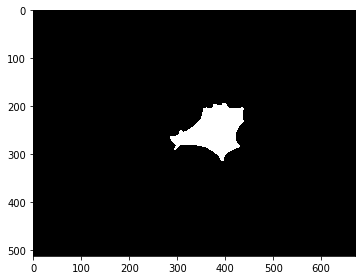

In [ ]:
imshow(mask[:,:,0])

In [ ]:
len(imagenames)

42

In [ ]:
#PREPARE MASKS AND AT THE END SAVE IN A DIFFERENT FOLDER
#DONE THIS WAY IN CASE WE ARE USING MASKS COMING FROM DIFFERENT TRAINING SET FOLDERS

#get only cells from combined (nuc,memb) mask
for imagename in imagenames:
  mask=imread(training_masks_folder+'/'+imagename)
  mask=mask[:,:,0]
  imsave(training_masks_folder+'/'+imagename, mask)

#rename files
for imagename in imagenames:
  os.rename(training_masks_folder+'/'+imagename,training_masks_folder+'/'+imagename[:-4]+'.TIF')

#get names of all masks
imagenames=os.listdir(training_masks_folder)

#copy individual images to maskdir
!cp {training_masks_folder}/* {maskdir}

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: 110619_bleb_nuc_memb_masks/110619_Sample1_s18_t1.tif is a low contrast image
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: 110619_bleb_nuc_memb_masks/110619_Sample1_s14_t1.tif is a low contrast image
  


In [ ]:
imagenames[0]

'110619_Sample1_s14_t26.TIF'

In [ ]:
#get names of all masks
imagenames=os.listdir(maskdir)

In [ ]:
#convert masks into files with only 0s and 5s in maskdir
for imagename in imagenames:
  mask=imread(maskdir+imagename)
  mask[mask>0]=5
  imsave(maskdir+imagename, mask)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: training_masks/110619_Sample1_s14_t26.TIF is a low contrast image
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: training_masks/110619_Sample1_s12_t51.TIF is a low contrast image
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: training_masks/110619_Sample1_s18_t1.TIF is a low contrast image
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: training_masks/110619_Sample1_s15_t26.TIF is a low contrast image
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: training_masks/110619_Sample1_s11_t51.TIF is a low contrast image
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: training_masks/110619_Sample1_s12_t1.TIF is a low contrast image
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: training_masks/110619_Sample1_s

/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


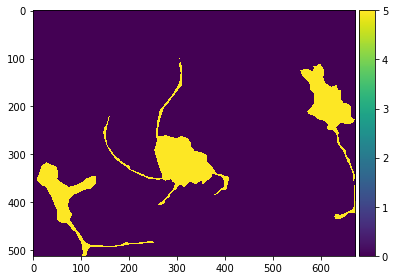

In [ ]:
mask=imread(maskdir+'/'+imagenames[1])
#hist=plt.hist(mask.ravel())
imshow(mask)

###Get and prepare images for training

In [ ]:
!gsutil cp gs://cellmbucket/110619_bleb.zip /{local_folder}

Copying gs://cellmbucket/110619_bleb.zip...
\ [1 files][426.0 MiB/426.0 MiB]                                                
Operation completed over 1 objects/426.0 MiB.                                    


In [ ]:
#this will unzip files on a folder 110619_bleb
!unzip 110619_bleb.zip

Archive:  110619_bleb.zip
   creating: 110619_bleb/
  inflating: 110619_bleb/110619_Sample1.nd  
  inflating: 110619_bleb/110619_Sample1_s10_t1.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t10.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t100.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t101.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t102.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t103.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t104.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t105.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t106.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t107.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t108.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t109.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t11.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t110.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t111.TIF  
  inflating: 110619_bleb/110619_Sample1_s10_t12.TIF  
  inflating: 110619_bleb/110

In [ ]:
imagesfolder='110619_bleb'

In [ ]:
#!cp -r /content/drive/My\ Drive/062719 /content 

In [ ]:
#%cd 062719
#!unzip 062719_sample1.zip
#!unzip 062719_sample2.zip
#%cd ..

In [ ]:
#make folder to store images for training
!mkdir imagestraining

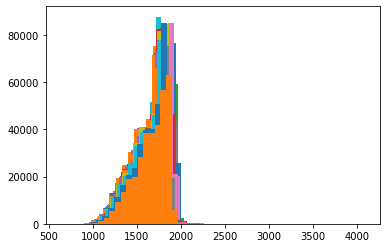

In [ ]:
for i in range(len(imagenames)):
  if imagenames[i].endswith('.TIF'):
    image=imread('/'+local_folder+'/'+ imagesfolder +'/'+imagenames[i])
    plt.hist(image.ravel(),50)

In [ ]:
#get images corresponding to masks, put them in 8 bit and rgb
for imagename in imagenames:
  bright = rescale_intensity(imread(imagesfolder+'/'+imagename),(700,2250))
  #convert to 8 bit from 16 bit
  bright8b= (bright/256).astype('uint8')
  #convert gray to rgb
  brigth8b_rgb=np.stack((bright8b,bright8b,bright8b),axis=2)
  imsave('./imagestraining/'+imagename, brigth8b_rgb)

In [ ]:
!ls

110619_bleb		    110619_bleb.zip  drive	     sample_data
110619_bleb_nuc_memb_masks  adc.json	     imagestraining  training_masks


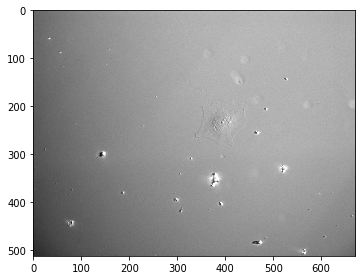

In [ ]:
image=imread('imagestraining/'+imagenames[0])
imshow(image)

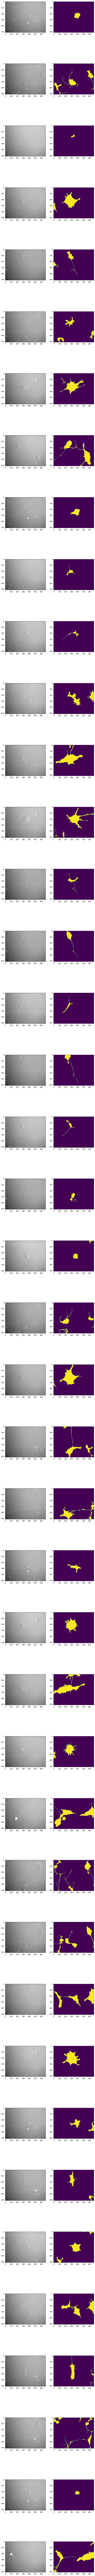

In [ ]:
f, axarr = plt.subplots(len(imagenames),2)
for i in range(len(imagenames)):
  mask=imread(maskdir+'/'+imagenames[i])
  image=imread('imagestraining/'+imagenames[i])

  axarr[i,0].imshow(image)
  axarr[i,1].imshow(mask)    
  f.set_size_inches(10,300)

###Prepare fast.ai data loader

In [ ]:
path=Path('/content')

In [ ]:
#codes = np.loadtxt(path/'codes.txt', dtype=str)

In [ ]:
#codes

In [ ]:
path2 = untar_data(URLs.CAMVID_TINY)

In [ ]:
codes2 = np.loadtxt(path2/'codes.txt', dtype=str)

In [ ]:
codes2

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car',
       'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv',
       'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving',
       'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk',
       'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel',
       'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [ ]:
def label_func(x): return path/maskdir/f'{x.stem}.TIF'
fnames = get_image_files(path/'imagestraining')
codes = np.loadtxt(path2/'codes.txt', dtype=str)

In [ ]:
#dls = SegmentationDataLoaders.from_label_func(
#    path, bs=4, fnames = get_image_files(path/'imagesbrightrgb'),
#    label_func = lambda o: path/'masks'/f'{o.stem}.png',
#    codes = np.loadtxt(path2/'codes.txt', dtype=str)
    
#)

In [ ]:
#dls = SegmentationDataLoaders.from_label_func(path,fnames,label_func,bs=4,codes=codes)

In [ ]:
trainingset = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                   get_items = get_image_files,
                   get_y = label_func,
                   splitter=RandomSplitter(),
                   #batch_tfms=aug_transforms(size=(512,672)))
                   batch_tfms=aug_transforms(size=(256,336)))

In [ ]:
dls = trainingset.dataloaders(path/"imagestraining", path=path, bs=8)


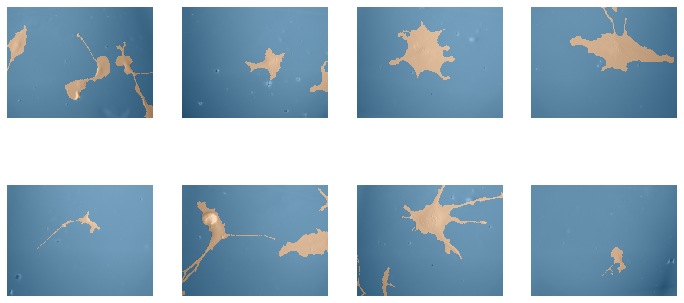

In [ ]:
dls.show_batch(max_n=10)

#Training

In [ ]:
#learn = unet_learner(dls, resnet34)
modelname='seg_cell_062719_s_1_2_110619_bleb.pkl'
!gsutil cp gs://cellmbucket/fastai_unet_models/{modelname} /{local_folder} 
loadedlearner=load_learner(modelname,cpu=True)
loadedlearner.dls=dls

Copying gs://cellmbucket/fastai_unet_models/seg_cell_062719_s_1_2_110619_bleb.pkl...
/ [1 files][217.9 MiB/217.9 MiB]                                                
Operation completed over 1 objects/217.9 MiB.                                    


In [ ]:
#learn.fine_tune(8)
loadedlearner.fine_tune(8)


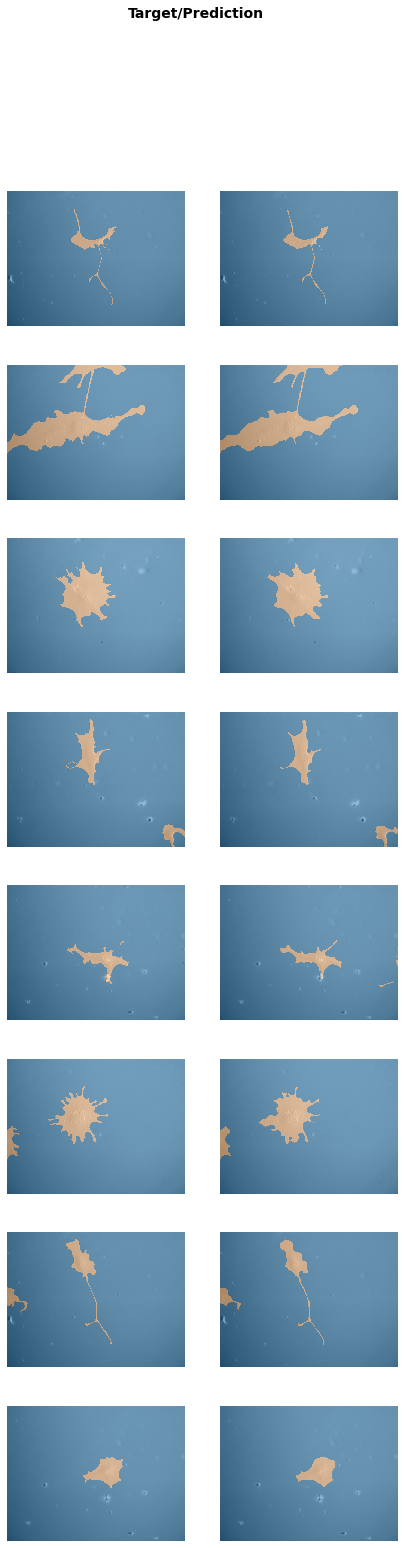

In [ ]:
loadedlearner.show_results(max_n=8, figsize=(7,25))

In [ ]:
loadedlearner.export(fname='seg_cell_062719_s_1_2_110619_bleb.pkl', pickle_protocol=2)

In [ ]:
!ls

110619_bleb		    imagestraining
110619_bleb_nuc_memb_masks  sample_data
110619_bleb.zip		    seg_cell_062719_s_1_2_110619_bleb.pkl
adc.json		    seg_nuc_062719_s_1_2_110619_bleb.pkl
drive			    training_masks


In [ ]:
!cp /content/seg_cell_062719_s_1_2_110619_bleb.pkl /content/drive/My\ Drive

# Loading a trained model

In [ ]:
#@markdown local folder is "content" when working in colab, may be different for GCP AI
local_folder='content' #@param

In [ ]:
## ONLY CELL MODEL
modelname="seg_cell_062719_s_1_2_110619_bleb.pkl"

!gsutil cp gs://cellmbucket/fastai_unet_models/{modelname} /{local_folder}

path=Path('/content')
path2 = untar_data(URLs.CAMVID_TINY)
codes2 = np.loadtxt(path2/'codes.txt', dtype=str)
maskdir='nuclear_masks/'
def label_func(x): return path/maskdir/f'{x.stem}.TIF'
fnames = get_image_files(path/'imagestraining')
codes = np.loadtxt(path2/'codes.txt', dtype=str)
loadedlearner=load_learner(modelname,cpu=True)

Copying gs://cellmbucket/fastai_unet_models/seg_cell_062719_s_1_2_110619_bleb.pkl...
/ [1 files][217.9 MiB/217.9 MiB]                                                
Operation completed over 1 objects/217.9 MiB.                                    


#Segment experiment

### Set folder names and paths

In [ ]:
#@markdown Path of the folder containing the movies in GCP bucket
movies_path="cellmbucket/05262021_Fascin_KO/trial1/sample3"  #@param {type:"string"}
#@markdown Name of the folder that will contain the masks
foldermasks= '05262021_Fascin_KO-sample3-cell-masks'  #@param {type:"string"}
#@markdown path of the folder on GCP bucket where the masks will be deposited as a .zip file
dest_path='cellmbucket/05262021_Fascin_KO/trial1/05262021_Fascin_KO-sample3-cell-masks.zip' #@param {type:"string"}

In [ ]:
folderimages= ntpath.basename(movies_path)

In [ ]:
foldermasks

'05262021_Fascin_KO-sample3-cell-masks'

In [ ]:
!mkdir {foldermasks}

### Get movies from GCP

In [ ]:
!gsutil -m cp -r gs://{movies_path} /content

Streaming output truncated to the last 5000 lines.
Copying gs://cellmbucket/05262021_Fascin_KO/trial1/sample3/052622021_Sample3_w1DIC_s16_t160.TIF...
Copying gs://cellmbucket/05262021_Fascin_KO/trial1/sample3/052622021_Sample3_w1DIC_s16_t161.TIF...
Copying gs://cellmbucket/05262021_Fascin_KO/trial1/sample3/052622021_Sample3_w1DIC_s16_t162.TIF...
Copying gs://cellmbucket/05262021_Fascin_KO/trial1/sample3/052622021_Sample3_w1DIC_s16_t163.TIF...
Copying gs://cellmbucket/05262021_Fascin_KO/trial1/sample3/052622021_Sample3_w1DIC_s16_t164.TIF...
Copying gs://cellmbucket/05262021_Fascin_KO/trial1/sample3/052622021_Sample3_w1DIC_s16_t166.TIF...
Copying gs://cellmbucket/05262021_Fascin_KO/trial1/sample3/052622021_Sample3_w1DIC_s16_t165.TIF...
Copying gs://cellmbucket/05262021_Fascin_KO/trial1/sample3/052622021_Sample3_w1DIC_s16_t167.TIF...
Copying gs://cellmbucket/05262021_Fascin_KO/trial1/sample3/052622021_Sample3_w1DIC_s16_t169.TIF...
Copying gs://cellmbucket/05262021_Fascin_KO/trial1/sample3

In [ ]:
!ls

05262021_Fascin_KO-sample3-cell-masks  sample3
adc.json			       sample_data
drive				       seg_cell_062719_s_1_2_110619_bleb.pkl


### Get number of movies and frames per movie, find image basename

In [ ]:
imagenames=[f for f in os.listdir(folderimages) if f.endswith('.TIF')]

In [ ]:
imagenames[0]

'052622021_Sample3_w1DIC_s28_t91.TIF'

In [ ]:
#Get movie numbers and show the largest number
listmovies=[int(re.findall(r"s(\d+).", imagenames[i])[0]) for i in range(len(imagenames)) ]
nmovies=max(listmovies)
movies=set(listmovies)
movies

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34}

In [ ]:
#Get frame numbers and show the largest number
listframes=[int(re.findall(r"t(\d+).", imagenames[i])[0]) for i in range(len(imagenames)) ]
nframes=max(listframes)
frames=range(1,nframes+1)
nframes

181

In [ ]:
re.findall(r"(.*)_s",imagenames[0])[0]

'052622021_Sample3_w1DIC'

In [ ]:
filenamebase='sample3' #@param {type:"string"}

### Set contrast range

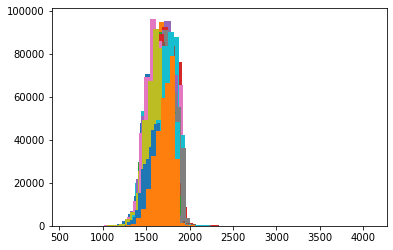

In [ ]:
imagenames=os.listdir(folderimages)
for i in range(1,len(imagenames),100):
  if imagenames[i][-3:]=='TIF':
    image=imread(folderimages + '/'+imagenames[i])
    plt.hist(image.ravel(),50)

In [ ]:
minpixelintensity=1000 #@param {type:"integer"}
maxpixelintensity=2200 #@param {type:"integer"}

###Test segmentation

In [ ]:
for i in range(1,16):
  if imagenames[i][-3:]=='TIF':
    bright = rescale_intensity(imread(filenamebase+'/'+imagenames[i]),(minpixelintensity,maxpixelintensity))
    #convert to 8 bit from 16 bit
    bright8b= (bright/256).astype('uint8')
    tosegment=np.stack((bright8b,bright8b,bright8b),axis=2)
    segmented = loadedlearner.predict(tosegment)[1]
    mask01=np.asarray(segmented)
    imsave(foldermasks+'/'+imagenames[i], mask01.astype('uint8'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t180.TIF is a low contrast image
  if __name__ == '__main__':


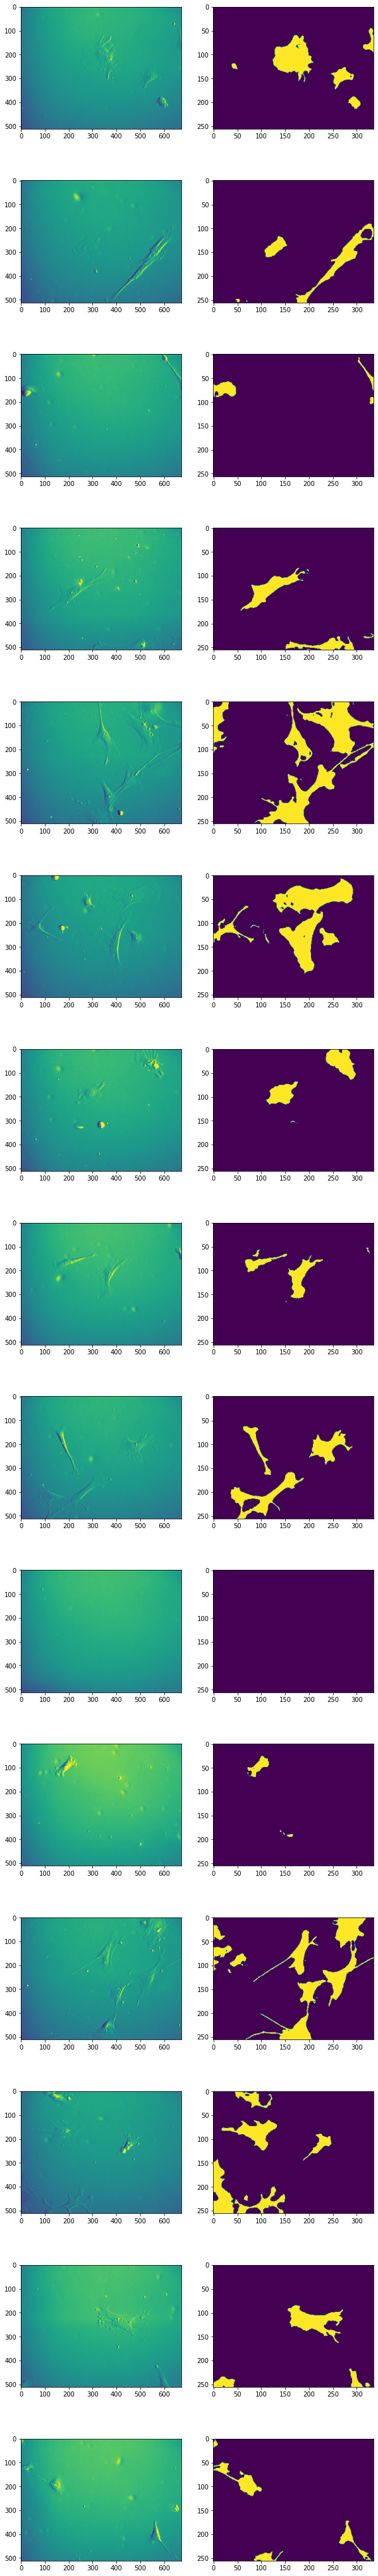

In [ ]:
masknames=os.listdir(foldermasks)
nimages=len(masknames)
f, axarr = plt.subplots(nimages,2)

for i in range(nimages):
  mask=imread(foldermasks+'/'+masknames[i])
  image=rescale_intensity(imread(folderimages+'/'+masknames[i]),(minpixelintensity,maxpixelintensity))

  axarr[i,0].imshow(image)
  axarr[i,1].imshow(mask)    
  f.set_size_inches(10,5*nimages)

###Segment experiment and save output

In [ ]:
for name in imagenames:
  if name[-3:]=='TIF':
    bright = rescale_intensity(imread(filenamebase+'/'+name),(minpixelintensity,maxpixelintensity))
    #convert to 8 bit from 16 bit
    bright8b= (bright/256).astype('uint8')
    tosegment=np.stack((bright8b,bright8b,bright8b),axis=2)
    segmented = loadedlearner.predict(tosegment)[1]
    mask01=np.asarray(segmented)
    imsave(foldermasks+'/'+name, mask01.astype('uint8'))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t111.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t132.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t30.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t38.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t50.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t115.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t99.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t16.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t118.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t120.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t39.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t148.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t47.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t78.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t80.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t67.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t33.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t134.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t68.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t137.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t110.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t11.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t141.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t168.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t107.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t178.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t15.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t61.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t145.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t144.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t66.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t91.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t60.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t31.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t32.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t129.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t138.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t70.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t181.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t71.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t49.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t18.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t146.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t17.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t44.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t151.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t93.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t13.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t159.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t59.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t82.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t171.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t55.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t172.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t135.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t64.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t116.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t114.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t94.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t19.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t89.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t98.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t54.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t152.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t40.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t167.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t57.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t117.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t158.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t37.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t20.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t65.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t142.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t170.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t6.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t161.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t175.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t74.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t21.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t79.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t76.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t26.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t108.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t28.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t85.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t103.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t3.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t22.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t84.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t102.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t147.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t42.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t56.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t8.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t27.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t7.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t23.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t113.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t63.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t133.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t52.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t124.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t174.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t96.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t88.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t36.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t104.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s14_t51.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s16_t119.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s19_t153.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s3_t4.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t90.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t105.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t179.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s32_t143.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t156.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t77.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t123.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t180.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t163.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t154.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t43.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t150.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t149.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t131.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t109.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s11_t164.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t73.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t34.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s13_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t46.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t72.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t162.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t122.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t97.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s22_t81.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t83.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t130.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t24.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t112.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t136.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t177.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t25.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t12.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t157.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t53.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t2.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t58.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t140.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t35.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t9.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t41.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s7_t176.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s8_t125.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t29.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t166.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s18_t139.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t10.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s21_t92.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s25_t62.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s10_t1.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t155.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s12_t69.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t106.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s6_t75.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s24_t173.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t101.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s5_t165.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s26_t169.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s27_t160.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t87.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s28_t127.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s33_t121.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t48.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t95.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s15_t100.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t126.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t45.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t86.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s17_t128.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s20_t5.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s30_t14.TIF is a low contrast image
  if __name__ == '__main__':


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s2_t30.TIF is a low contrast image
  if __name__ == '__main__':


In [ ]:
!zip -r {foldermasks}.zip {foldermasks}

Streaming output truncated to the last 5000 lines.
  adding: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s4_t132.TIF (deflated 99%)
  adding: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s9_t103.TIF (deflated 99%)
  adding: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s29_t150.TIF (deflated 100%)
  adding: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s34_t125.TIF (deflated 100%)
  adding: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s1_t14.TIF (deflated 99%)
  adding: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s31_t144.TIF (deflated 100%)
  adding: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t156.TIF (deflated 98%)
  adding: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t110.TIF (deflated 98%)
  adding: 05262021_Fascin_KO-sample3-cell-masks/052622021_Sample3_w1DIC_s23_t1.TIF (deflated 99%)
  adding: 05262021_Fascin_KO-sample3-cell-masks/0526

In [ ]:
!gsutil -m cp /content/{foldermasks}.zip gs://{dest_path}  

Copying file:///content/05262021_Fascin_KO-sample3-cell-masks.zip [Content-Type=application/zip]...
-
Operation completed over 1 objects/7.0 MiB.                                      
